In [1]:
from opt.mc_sim import *
import time
from common.variables import *

In [2]:
import pickle as pkl
from opt.eval_policy import *

# filename = "output/msource_value_dic_06-16-2022-09-56-03.pkl"
# filename = "output/msource_value_dic_06-22-2022-03-55-05.pkl"
filename = "output/msource_value_dic_06-22-2022-03-55-05.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

In [3]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 30,
  'nested_mc_iters': 30,
  'mc_episodes': 30,
  'max_steps': 30,
  'explore_eps': 0.05,
  'debug_bool': 0,
  'fixed_learn_rate': 0.1},
 'policy_params': {'h_cost': 1,
  'b_penalty': 5,
  'small_s': 2,
  'big_s': 15,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 4,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0},
 'git_commit': 'no_git',
 'branch_name': 'no_git'}

In [4]:
# best_small_s, best_big_s, best_val = find_opt_ss_policy_via_mc(sourcingEnv, periods = 20, nested_mc_iters = 50)
# best (s, S) policy found by MC:: (2, 5)

In [5]:
# model_params['branch_name'], model_params['git_commit']

In [6]:
# sourcingEnv = SourcingEnv(
#         lambda_arrival = 8, # or 10
#         procurement_cost_vec = np.array([3, 1, 2]),
#         supplier_lead_times_vec = np.array([0.8, 0.5, 1.0]),
#         on_times = np.array([1, 1, 2]), 
#         off_times = np.array([0.3, 1, 0.2]))

# Dual Sourcing
# sourcingEnv = SourcingEnv(
#         lambda_arrival = LAMBDA, # or 10
#         procurement_cost_vec = np.array([3, 1]),
#         supplier_lead_times_vec = np.array([0.8, 0.5]),
#         on_times = np.array([1, 1]), 
#         off_times = np.array([0.3, 1]))

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

mc_avg_costs = mc_with_ss_policy(sourcingEnv, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 100,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'])


# print(mc_avg_costs)

In [7]:
# mc_avg_costs = mc_with_ss_policy(sourcingEnv, 
#     periods = 100,
#     nested_mc_iters = 50,
#     big_s = 5,
#     small_s = 2,
#     h_cost = model_params['policy_params']['h_cost'],
#     b_penalty = model_params['policy_params']['b_penalty'])

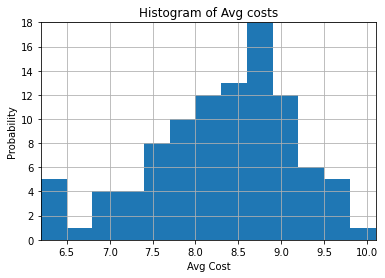

In [8]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 0.3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [9]:
print(np.mean(np.array(mc_avg_costs)))

8.298666666666668


In [10]:
np.std(np.array(mc_avg_costs))

0.8503844882038816

In [11]:
print(sourcingEnv.reset())

Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]


In [12]:
repr(str(sourcingEnv.reset()))

"'Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]'"

In [13]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 30,
  'nested_mc_iters': 30,
  'mc_episodes': 30,
  'max_steps': 30,
  'explore_eps': 0.05,
  'debug_bool': 0,
  'fixed_learn_rate': 0.1},
 'policy_params': {'h_cost': 1,
  'b_penalty': 5,
  'small_s': 2,
  'big_s': 15,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 4,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0},
 'git_commit': 'no_git',
 'branch_name': 'no_git'}

In [14]:
# try a bit of indifference rounding
# for k in value_dic.keys():
#     value_dic[k] = round(value_dic[k], 3)


In [15]:
eval_steps = 30
mc_eval_iter = 30
eval_costs_ss = mc_eval_policy_perf(sourcingEnv, value_dic, 
    max_steps = eval_steps, 
    mc_iters = mc_eval_iter,
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'], 
    policy_callback = eval_policy_from_ss_pol)

avg_eval_cost_ss = np.mean(eval_costs_ss)
avg_eval_cost_ss

MC eval iter: 0
MC eval iter: 1
MC eval iter: 2
MC eval iter: 3
MC eval iter: 4
MC eval iter: 5
MC eval iter: 6
MC eval iter: 7
MC eval iter: 8
MC eval iter: 9
MC eval iter: 10
MC eval iter: 11
MC eval iter: 12
MC eval iter: 13
MC eval iter: 14
MC eval iter: 15
MC eval iter: 16
MC eval iter: 17
MC eval iter: 18
MC eval iter: 19
MC eval iter: 20
MC eval iter: 21
MC eval iter: 22
MC eval iter: 23
MC eval iter: 24
MC eval iter: 25
MC eval iter: 26
MC eval iter: 27
MC eval iter: 28
MC eval iter: 29


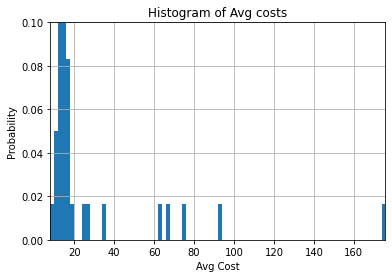

In [16]:
import numpy as np

eval_costs_scaled_ss = np.array(eval_costs_ss)/eval_steps
binwidth = 2.0

n, bins, patches = plt.hist(eval_costs_scaled_ss, bins=np.arange(min(eval_costs_scaled_ss), max(eval_costs_scaled_ss) + binwidth, binwidth), density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(eval_costs_scaled_ss), np.max(eval_costs_scaled_ss))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [17]:
np.mean(eval_costs_scaled_ss)

29.11444444444444

In [ ]:
np.std(eval_costs_scaled_ss)

In [18]:
eval_steps = 30
mc_eval_iter = 30
eval_costs = mc_eval_policy_perf(sourcingEnv, value_dic, 
    max_steps = eval_steps, 
    mc_iters = mc_eval_iter,
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'])

avg_eval_cost = np.mean(eval_costs)

MC eval iter: 0
MC eval iter: 1
MC eval iter: 2
MC eval iter: 3
MC eval iter: 4
MC eval iter: 5
MC eval iter: 6
MC eval iter: 7
MC eval iter: 8
MC eval iter: 9
MC eval iter: 10
MC eval iter: 11
MC eval iter: 12
MC eval iter: 13
MC eval iter: 14
MC eval iter: 15
MC eval iter: 16
MC eval iter: 17
MC eval iter: 18
MC eval iter: 19
MC eval iter: 20
MC eval iter: 21
MC eval iter: 22
MC eval iter: 23
MC eval iter: 24
MC eval iter: 25
MC eval iter: 26
MC eval iter: 27
MC eval iter: 28
MC eval iter: 29


In [19]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 30,
  'nested_mc_iters': 30,
  'mc_episodes': 30,
  'max_steps': 30,
  'explore_eps': 0.05,
  'debug_bool': 0,
  'fixed_learn_rate': 0.1},
 'policy_params': {'h_cost': 1,
  'b_penalty': 5,
  'small_s': 2,
  'big_s': 15,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 4,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0},
 'git_commit': 'no_git',
 'branch_name': 'no_git'}

In [20]:
eval_costs_scaled = np.array(eval_costs)/eval_steps

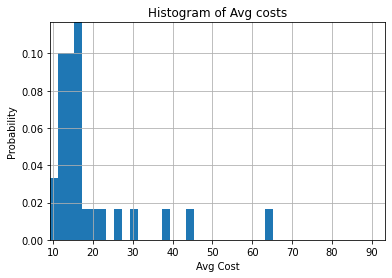

In [21]:
import numpy as np

binwidth = 2.0

n, bins, patches = plt.hist(eval_costs_scaled, bins=np.arange(min(eval_costs_scaled), max(eval_costs_scaled) + binwidth, binwidth), density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(eval_costs_scaled), np.max(eval_costs_scaled))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [22]:
np.median(eval_costs_scaled)

15.583333333333332

In [23]:
np.std(eval_costs_scaled)

17.631280983972847

In [24]:
len(list(value_dic.keys()))

72780

-7.272222222222223

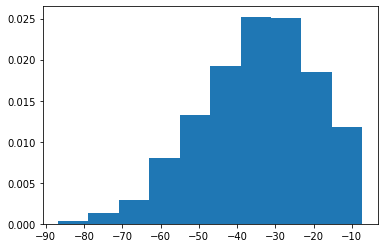

In [25]:
import numpy as np

binwidth = 0.3

state_vals = [x[0] for x in list(value_dic.values())]
state_visits = [x[1] for x in list(value_dic.values())]

n, bins, patches = plt.hist(state_vals, density = True)
np.max(state_vals)

99

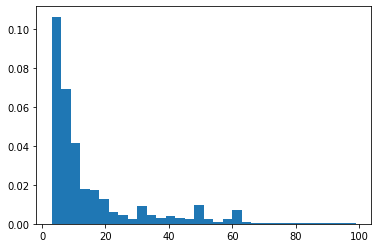

In [26]:
binwidth = 3
state_visits.remove(1)
state_visits_massage = [x for x in state_visits if 100 > x > 2]

n, bins, patches = plt.hist(state_visits_massage, bins=np.arange(min(state_visits_massage), max(state_visits_massage) + binwidth, binwidth), density = True)
np.max(state_visits_massage)

In [27]:
np.min(state_visits_massage)

3

In [28]:
len(set(state_visits))

285

In [29]:
len(state_visits_massage) - len(state_visits)

-29485

In [30]:
len(state_visits)

72779

In [31]:
len(state_vals)

72780

In [32]:

max(value_dic, key=value_dic.get)


'[6, 1, 0, 1, 0]'

In [33]:
min(value_dic, key=value_dic.get)

'[22, 29, 45, 1, 1]'

In [34]:
value_dic_key_sorted = sorted(value_dic, key=value_dic.get, reverse=True)
value_dic_value_sorted = sorted(value_dic.values(), reverse=True)

In [35]:
value_diagnostic = list(zip(value_dic_key_sorted, value_dic_value_sorted))

In [36]:
value_diagnostic

[('[6, 1, 0, 1, 0]', (-7.272222222222223, 23)),
 ('[4, 2, 6, 1, 1]', (-7.31, 1)),
 ('[7, 3, 0, 1, 1]', (-7.382222222222221, 23)),
 ('[7, 1, 0, 0, 0]', (-7.448344444444444, 23)),
 ('[7, 2, 0, 1, 1]', (-7.457333333333333, 23)),
 ('[6, 2, 0, 1, 0]', (-7.45967, 23)),
 ('[7, 2, 0, 1, 0]', (-7.460333333333333, 66)),
 ('[6, 5, 1, 0, 1]', (-7.48111111111111, 1)),
 ('[7, 2, 0, 0, 0]', (-7.4893888888888895, 23)),
 ('[7, 4, 2, 1, 1]', (-7.513333333333334, 2)),
 ('[5, 5, 1, 1, 1]', (-7.5411111111111095, 1)),
 ('[8, 0, 0, 0, 0]', (-7.568888888888891, 22)),
 ('[8, 1, 0, 0, 0]', (-7.572601425555557, 44)),
 ('[8, 0, 0, 1, 1]', (-7.572638555555557, 22)),
 ('[2, 8, 1, 1, 1]', (-7.583333333333333, 1)),
 ('[9, 0, 0, 1, 1]', (-7.585555555555556, 21)),
 ('[5, 0, 6, 1, 1]', (-7.602222222222222, 1)),
 ('[4, 6, 0, 1, 1]', (-7.607777777777779, 1)),
 ('[4, 0, 6, 1, 1]', (-7.608888888888889, 1)),
 ('[8, 1, 2, 1, 1]', (-7.60888888888889, 1)),
 ('[4, 1, 6, 1, 1]', (-7.612222222222221, 1)),
 ('[5, 6, 1, 0, 1]', (-7.

In [37]:
with open('output/diagnostic_output.txt', 'w') as f:
    for item in value_diagnostic:
        f.write("{i}\n".format(i = str(item)) )

In [38]:
item

('[22, 29, 45, 1, 1]', (-86.83222222222221, 1))

In [39]:
len(value_dic)

72780